<a href="https://colab.research.google.com/github/Rishit-dagli/tensorflow/blob/get-started-with-cnn/tensorflow/examples/get_started/get-started-with-cnn/cnn_with_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get started with CNNs
(Author: [Rishit Dagli](https://www.rishit.tech))

In this tutorial you will se how you can create a simple CNN to create an image cllassification algorithm with the [Fashion MNIST](https://www.tensorflow.org/datasets/catalog/fashion_mnist) Dataset. We will be using Keras, a high level abstraction so you can very easily get started on making your first CNN.


## What is a CNN?

[Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) or CNNs are all about learning features. Traditional fully connected Deep Neural Networks often do not tend to scale well while working with images. This usually happens due to the fact that in an image you essentially want to extract features.

Features like if there is a certain set of things like a strap and a bag maybe then it's a handbag and so on. I want my model to be able to learn these kind of relations in the data. CNNs allow you to highlight these core features that distinguish one item for another. You would then train on just these highlighted features.

In this notebook we will be using TensorFlow version 2.x

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

import tensorflow as tf
print(tf.__version__)

2.2.0


## Loading the data

You will now load the [Fashion MNIST dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist). The Fashion MNIST dataset is already a part of `tf.keras.datsets` so you can go and get the MNIST dataset directly from there.

### [The Fashion MNIST dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist)

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.

The class labels are:

|Labels |Description |
|:-----:|------------|
|0	    |T-shirt/top |
|1	    |Trouser     |
|2	    |Pullover    |
|3	    |Dress       |
|4	    |Coat        |
|5	    |Sandal      |
|6	    |Shirt       |
|7	    |Sneaker     |
|8	    |Bag         |
|9	    |Ankle boot  |

With `tf.keras.datasets` loading datasets becomes vey easy. You can use the [`load_data()`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) method to do so. Running the `load_data()` method returns Tuple of [`numpy`](https://numpy.org/) arrays: `(x_train, y_train), (x_test, y_test)`.

License:
The copyright for Fashion-MNIST is held by Zalando SE. Fashion-MNIST is licensed under the [MIT license](https://github.com/zalandoresearch/fashion-mnist/blob/master/LICENSE).

In [2]:
mnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

training_images = training_images.reshape(60000, 28, 28, 1) # Training images
test_images = test_images.reshape(10000, 28, 28, 1) # Testing images

## Some preprocessing

Since this is a very simple dataset to work with very little pre-processing would be required. We will divide all pixel values with 255 to covert them from the range 0 - 255 to 0 - 1. As Neural Nets tend to work better with normalized data. 

In [3]:
training_images = training_images / 255.0
test_images = test_images / 255.0

## Understanding Filters and Convolutions

Filters are the tools that provide great power to CNNs in finding the features. Lets take a look at how this works.

For every pixel, take its value, and take a look at the value of its neighbors. If our filter is three by three, then we can take a look at the immediate neighbor, so that you have a corresponding 3 by 3 grid. Then to get the new value for the pixel, we simply multiply each neighbor by the corresponding value in the filter.

![](https://github.com/Rishit-dagli/tensorflow/blob/get-started-with-cnn/tensorflow/examples/get_started/get-started-with-cnn/images/intro_to_filters.jpeg?raw=true)

So, for example, in this case, our pixel has the value 192, and its upper left neighbor has the value 0. The upper left value and the filter is -1, so we multiply 0 by -1. Then we would do the same for the upper neighbor. Its value is 64 and the corresponding filter value was 0, so we’d multiply those out.
Repeat this for each neighbor and each corresponding filter value, and would then have the new pixel with the sum of each of the neighbor values multiplied by the corresponding filter value, and that’s a convolution.

## Performing simple feature extraction with filters

Let's see a simple filter working on an image . With filters we will see how we can identify features with it, in this case vertical lines

### Identifying Vertical lines

Displaying our original image.

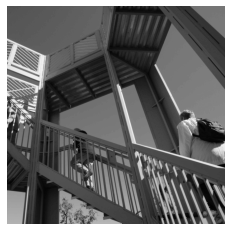

In [4]:
i = misc.ascent()
plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(i)
plt.show()

Identifying horizontal lines.

In [5]:
i_transformed = np.copy(i)
size_x = i_transformed.shape[0]
size_y = i_transformed.shape[1]

In [6]:
def transform_and_display(filter, image):
  for x in range(1,size_x-1):
    for y in range(1,size_y-1):
        convolution = 0.0
        convolution = convolution + (i[x - 1, y-1] * filter[0][0])
        convolution = convolution + (i[x, y-1] * filter[0][1])
        convolution = convolution + (i[x + 1, y-1] * filter[0][2])
        convolution = convolution + (i[x-1, y] * filter[1][0])
        convolution = convolution + (i[x, y] * filter[1][1])
        convolution = convolution + (i[x+1, y] * filter[1][2])
        convolution = convolution + (i[x-1, y+1] * filter[2][0])
        convolution = convolution + (i[x, y+1] * filter[2][1])
        convolution = convolution + (i[x+1, y+1] * filter[2][2])
        if(convolution<0):
          convolution=0
        if(convolution>255):
          convolution=255
        image[x, y] = convolution
  plt.gray()
  plt.grid(False)
  plt.imshow(i_transformed)
  #plt.axis('off')
  plt.show()   

We will finally now transform the image to highlight vertical lines

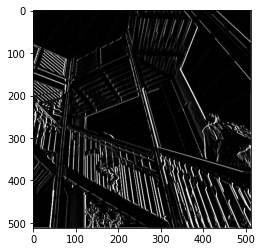

In [7]:
transform_and_display([ [-1, -2, -1], [0, 0, 0], [1, 2, 1]], i_transformed)

## Understanding Pooling

You might now see that while using a convolutional layer, it produces a large amount of data. We need to do something to optiize this. [Pooling](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling) is a way of compressing the image.

Let's say you select to have 2 x 2 pooling, what this means your model will take exclusive 2 x 2 pixel sets in the image. The model would then see all the pixel values in the selected 2 x 2 pixels and discard all of them but the pixel with largest value. The model would do this over and over until it covers the complete image. And there you have it! your image is reduced by 4 times and you still have the highlighted features (pixels with larger values) in the image.

## Implementing Convolutional layers in TensorFLow

**Do you need to know about how to do this operations we talked about and write them each time? The answer is No!**

TensorFlow makes it super easy for you to build CNNs without having to do the mathematical part or run into problems with managing your data. Lets see this how we can do this.

### Convolutions

Convolutions are defined as `Conv2D` in TensorFlow. A single layer is defined as-

```py
tf.keras.layers.Conv2D([filters], [kernel_size], activation = [activation_function]),
```

Since this is a getting started guide we have discussed just the bassic arguments. However, TensorFlow provides a lot of options to work with, [`tf.keras.layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

### Pooling 

Pooling layers can easily defined as `MaxPooling2D`-

```py
tf.keras.layers.MaxPooling2D([pool_size])
```

[`tf.keras.layers.MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

Rest of the part would be similar to creating a Deep Neural Network, lets make the model with 2 convolutional layers followed by max pooling.

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

> You are recommended to run the below code cell on a GPU

We will now `compile` and `fit` the model. We will do this just for 10 epochs as this is a very small dataset. This would take 1 - 2 minutes to run.

In [9]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(training_images, training_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6011 - accuracy: 0.7781
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.4015 - accuracy: 0.8521
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3449 - accuracy: 0.8737
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3091 - accuracy: 0.8845
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2807 - accuracy: 0.8967
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2610 - accuracy: 0.9034
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2390 - accuracy: 0.9106
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2272 - accuracy: 0.9158
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2118 - accuracy: 0.9218
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

### Accuracy and loss curves

Let's build an accuracy and loss curve to see how well the model performs. We will use `matplotlib` to do so.

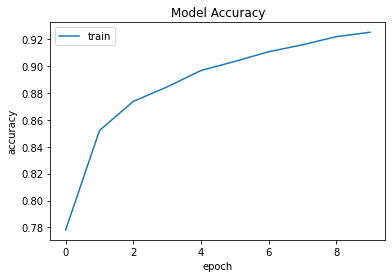

In [11]:
# Accuracy curve

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

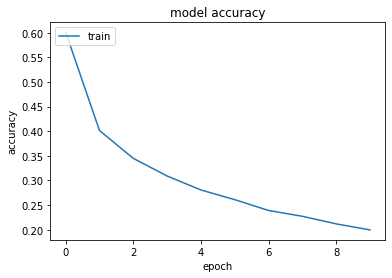

In [12]:
# Loss curve

plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Test accuracy

Remember we had those 10,000 images in the testing set lets make our model do inferences on that set of images.

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.3064 - accuracy: 0.8982
0.8981999754905701


## Visualizing the Convolutions and Pooling

This code will show us the convolutions graphically. The

```py
print (test_labels[;100])
```

shows us the first 100 labels in the test set, and you can see that the ones at index 0, index 23 and index 28 are all the same value (9). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the DNN is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

<details>
<summary>Credits</summary>
Credits for the code in this section go to Laurence Moroney - http://www.laurencemoroney.com/
</details>

In [14]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


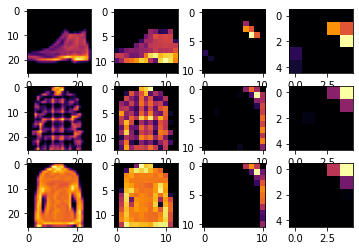

In [15]:
f, axarr = plt.subplots(3,4)
FIRST_IMAGE=0
SECOND_IMAGE=7
THIRD_IMAGE=26
CONVOLUTION_NUMBER = 1
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)
for x in range(0,4):
  f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[0,x].grid(False)
  f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[1,x].grid(False)
  f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
  axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
  axarr[2,x].grid(False)

## Save the model for future use

We will now save this model in the TensorFLow `SavedModel` format. You can easily do this by he `save()` method.

In [16]:
model.save('fashion_mnist_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: fashion_mnist_model/assets


## References

*   [Conv2D Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
*   [MaxPool2D Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
*   [Using Convolutional Neural Networks with TensorFlow by Rishit Dagli](https://medium.com/@rishit.dagli/using-convolutional-neural-networks-with-tensorflow-part-3-35de28a5621)
*   [Extending what Convolutional nets can do by Rishit Dagli](https://medium.com/@rishit.dagli/extending-what-convolutional-nets-can-do-251f3021529c)
*   [Visulaizing Convolutions by Laurence Moroney](https://github.com/lmoroney/dlaicourse/blob/842e3b1099082dc8631301c26afb6ec71f158eee/Horse_or_Human_NoValidation.ipynb)